In [1]:
import DistCor, RegDep
from sklearn import linear_model
from causalgraphicalmodels import CausalGraphicalModel
import numpy as np
import pandas as pd
import random
import generate_network
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
where_data = "/home/andy/Distance_correlation_data/network_backgrounds/"


In [2]:
def findsubsets(s, n):
    return list(map(list, itertools.combinations(s, n)))


def plot_hypothesis_test(tstat, background, subset, threshold, d_separated, ax, bins=50):
    sns.distplot(background, ax=ax, kde=False, bins=bins)
    ax.plot(tstat, 0, "o")
    minimal = np.percentile(background, threshold / 2)
    maximal = np.percentile(background, 100 - (threshold / 2))
    line_style = "-" if d_separated else ":"
    ax.axvline(minimal, ls=line_style)
    ax.axvline(maximal, ls=line_style)
    ax.set_ylabel(subset, rotation=0, labelpad=12 + len(subset))
    ax.set_yticks([])
    estimated_independence = True
    if (tstat < minimal) or (maximal < tstat):
        estimated_independence = False
    if d_separated != estimated_independence:
        ax.set_facecolor("#FFCCCC")
    return ax

def conditionally_independent(tstat, background, threshold):
    minimal = np.percentile(background, threshold / 2)
    maximal = np.percentile(background, 100 - (threshold / 2))
    estimated_independence = True
    if (tstat < minimal) or (maximal < tstat):
        estimated_independence = False
    return estimated_independence

def give_critical_values(background, threshold=5):
    return np.percentile(background, threshold / 2), np.percentile(background, 100 - (threshold / 2))
   

def give_confusion_matrix(tstats, backgrounds, threshold, d_separateds):
    n = len(backgrounds)
    predicted_independence = []
    for i in range(n):
        predicted_independence.append(conditionally_independent(tstats[i], backgrounds[i], threshold))
    return metrics.confusion_matrix(d_separateds, predicted_independence, labels=[True, False])
    
def read_in_data(director, model_name, pair, conditioning_size, method):
    saving_prefix = director + model_name + "_" + "-".join(pair) + "_" + str(conditioning_size)
    data = {}
    test_stats = np.load(f"{saving_prefix}_{method}_STATS.npy")
    times = np.load(f"{saving_prefix}_{method}_TIMES.npy")
    backgrounds = np.load(f"{saving_prefix}_{method}_BACKGROUNDS.npy")
    with open(f"{saving_prefix}_{method}_SUBSETS.txt", "r") as hand:
        subsets = list(map(str.strip, hand.readlines()))
    if len(subsets) > 1 and subsets[-1] == "":
        subsets = subsets[:-1]
    
    return test_stats, times, backgrounds, subsets

def plot_all_conditionings(tstats, backgrounds, subsets, threshold, d_separateds, figax = None, bins=50):
    n = len(backgrounds)
    if figax == None:
        fig, ax = plt.subplots(n, 1, figsize = (10, 3 * n))
    else:
        fig, ax = figax
    if n == 1:
        ax = [ax]
    for i in range(n):
        ax[i] = plot_hypothesis_test(tstats[i], backgrounds[i], subsets[i], threshold, d_separateds[i], ax[i])
    return fig, ax

def d_separation_dict(file_name):
        
    d_separated_lines = []
    with open(file_name, "r") as hand:
        d_separated_lines = list(map(str.strip, hand.readlines()))
    d_dict = {}
    for line in d_separated_lines:
        variables, conds = line.split("_")
        if variables in d_dict.keys():
            d_dict[variables].append(conds)
        else:
            d_dict[variables] = [conds]
    for key in d_dict.keys():
        d_dict[key] = sorted(d_dict[key])
    return d_dict


def give_d_separateds(pair, subsets, d_dict):
    d_separateds = []
    if pair in d_dict.keys():
        for subset in subsets:
            subset = subset.replace(",", "-")
            if subset in d_dict[pair]:
                d_separateds.append(True)
            else:
                d_separateds.append(False)
    else:
        d_separateds = len(subsets) * [False]
    return d_separateds


def read_data(where_to_dir, model_name, pair, conditioning_size, method):
    test_stats, times, backgrounds, subsets = read_in_data(where_to_dir, model_name, pair, conditioning_size, method)
    
    sorted_data = sorted(zip(test_stats, backgrounds.tolist(), times.tolist(), subsets), reverse=True)
    for i in range(len(subsets)):
        d = [sorted_data[i] for i in range(len(subsets)) if ((pair[0] not in sorted_data[i][-1]) and (pair[1] not in sorted_data[i][-1]))]
    tstats, backs, tim, subs = zip(*d)
    return tstats, backs, tim, subs


def give_conditioning_confusions(net, where_data, method, nsamp, parametrization, threshold):
    data_fr = pd.read_csv(where_data + f"net{net}/data_for_net{net}-{nsamp}-{parametrization}.csv", index_col=0)
    model_name = f"net{net}-{nsamp}-{parametrization}"
    subsets_to_calculate = findsubsets(data_fr.columns, 2)
    where_to_dir = where_data + f"net{net}/"
    conditioning_confusions = []
    for conditioning_size in range(len(data_fr.columns) - 2 + 1):
        confusions = []
        for pair in subsets_to_calculate:
            t, b, _, s = read_data(where_to_dir, model_name, pair, conditioning_size, method)
            d_dict = d_separation_dict(where_to_dir + f"net{net}_d-separations.txt")
            d_separateds = give_d_separateds("-".join(pair), s, d_dict)

            confusions.append(give_confusion_matrix(t, b, threshold, d_separateds))

        conditioning_confusions.append(sum(confusions))
    return conditioning_confusions

In [3]:


def confusion_plots(where_data, method, nsamp, parametrization, threshold):
    net1 = sum(give_conditioning_confusions(1, where_data, method, nsamp, parametrization, threshold))
    net2 = sum(give_conditioning_confusions(2, where_data, method, nsamp, parametrization, threshold))
    net3 = sum(give_conditioning_confusions(3, where_data, method, nsamp, parametrization, threshold))
    net4 = sum(give_conditioning_confusions(4, where_data, method, nsamp, parametrization, threshold))
    general = sum([net1, net2, net3, net4])

    fig = plt.figure(constrained_layout=False, figsize=(8, 10))
    gs = fig.add_gridspec(5, 4)

    vmax= 1322
    f_ax1 = fig.add_subplot(gs[:4, :])
    sns.heatmap(general, annot=True, fmt="d", linewidths=.5, ax=f_ax1, annot_kws={"size": 100}, cmap="viridis", vmin=0, vmax=vmax, cbar=False)#, xticklabels=["+", "-"], yticklabels=["True", "False"])
    f_ax1.xaxis.tick_top()
    f_ax2 = fig.add_subplot(gs[4,0])
    sns.heatmap(net1, annot=True, fmt="d", linewidths=.5, ax=f_ax2, annot_kws={"size": 25}, cmap="viridis", vmin=0, vmax=vmax, cbar=False, xticklabels=False, yticklabels=False)

    f_ax3 = fig.add_subplot(gs[4, 1])
    sns.heatmap(net2, annot=True, fmt="d", linewidths=.5, ax=f_ax3, annot_kws={"size": 25}, cmap="viridis", vmin=0, vmax=vmax, cbar=False, xticklabels=False, yticklabels=False)

    f_ax4 = fig.add_subplot(gs[4, 2])
    sns.heatmap(net3, annot=True, fmt="d", linewidths=.5, ax=f_ax4, annot_kws={"size": 25}, cmap="viridis", vmin=0, vmax=vmax, cbar=False, xticklabels=False, yticklabels=False)

    f_ax5 = fig.add_subplot(gs[4, 3])
    sns.heatmap(net4, annot=True, fmt="d", linewidths=.5, ax=f_ax5, annot_kws={"size": 25}, cmap="viridis", vmin=0, vmax=vmax, cbar=False, xticklabels=False, yticklabels=False)

    plt.subplots_adjust(wspace=0.05, hspace=0.05, bottom=0.01, right=0.99, top=0.99, left=0.01) #top=0.97, left=0.04,)
    plt.savefig(f'Confusion_{method}-{nsamp}-{parametrization}.png', dpi=200)
    return general

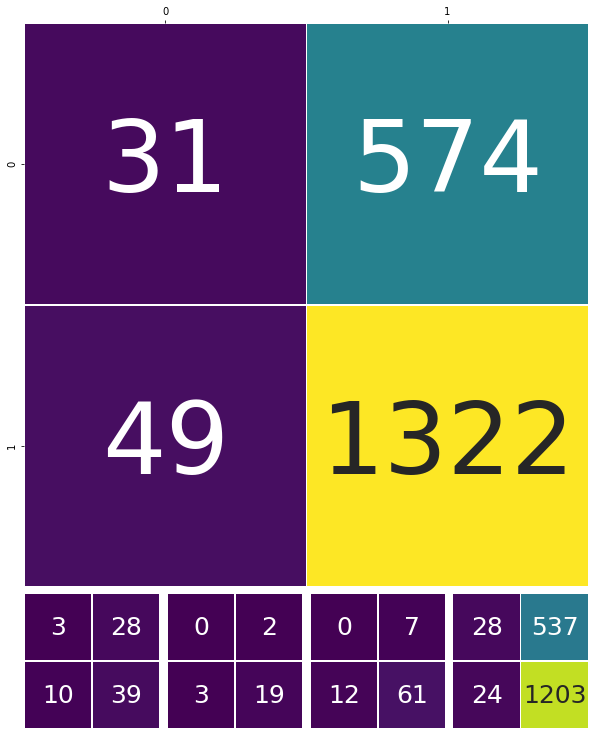

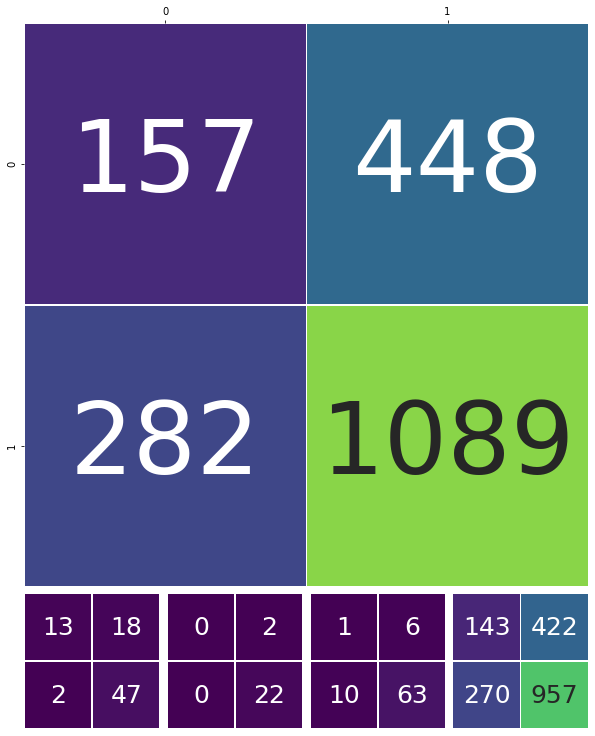

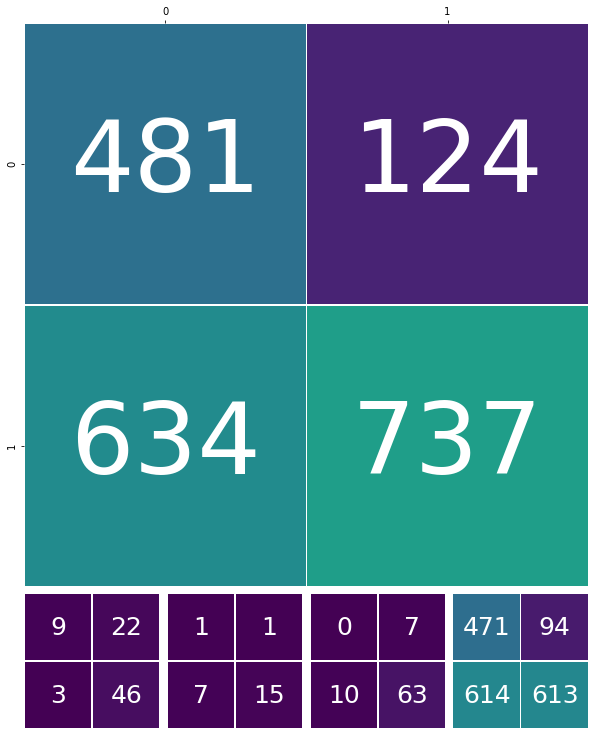

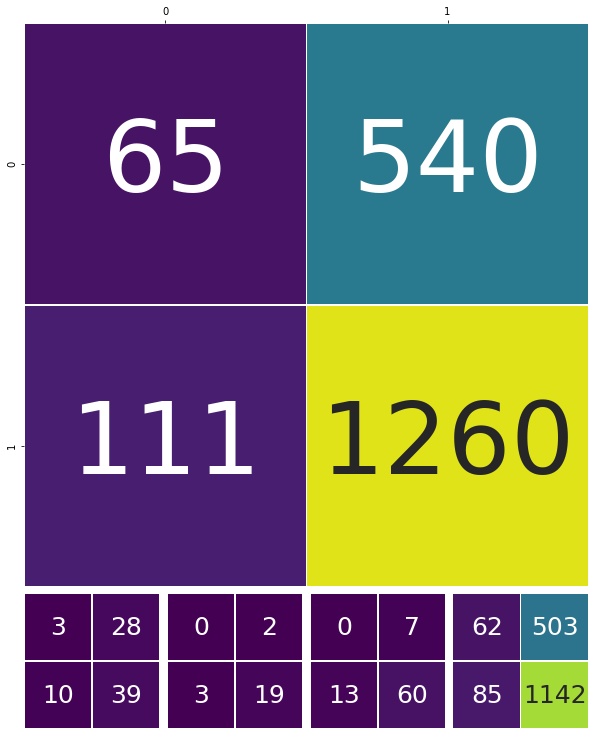

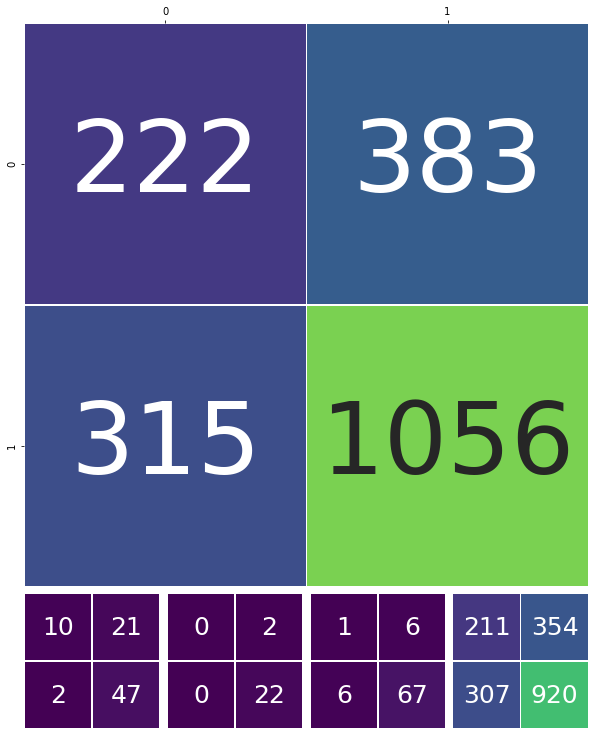

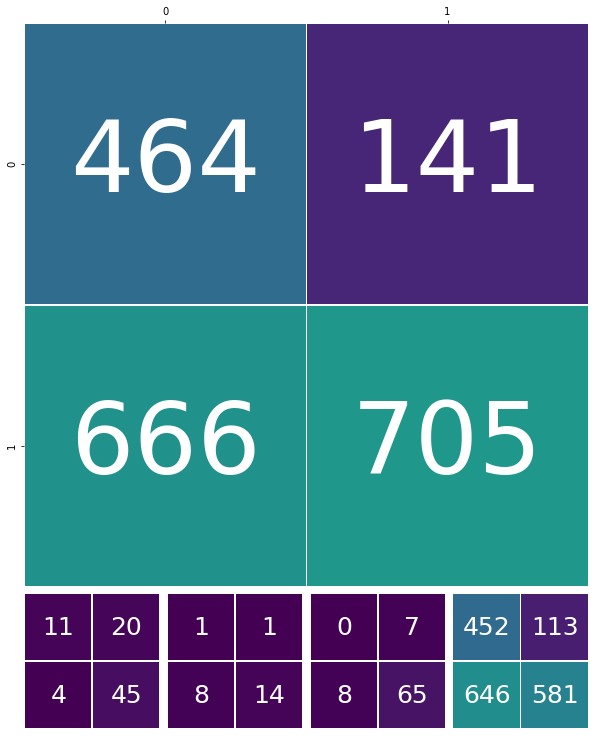

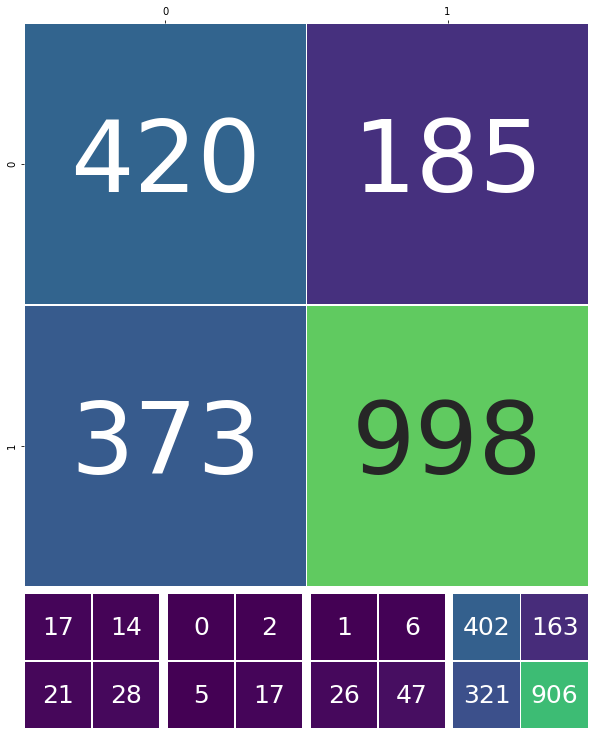

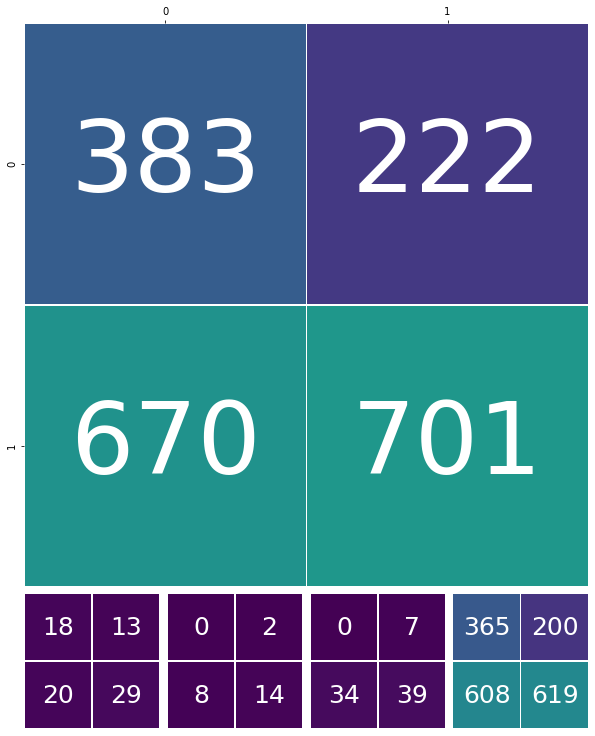

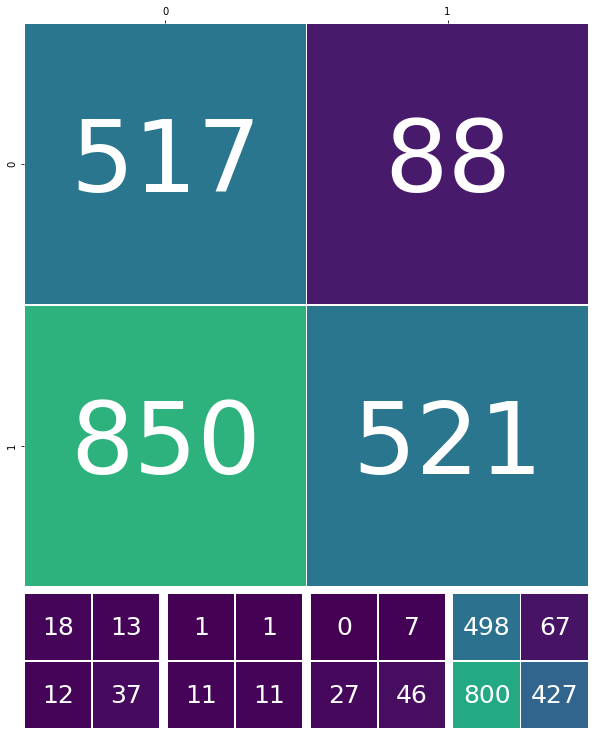

In [4]:

nsamp = 150

threshold = 5
maxi = 0
for method in ["DistCor", "DistResid", "partial_Cor"]:
    for parametrization in ["linear", "quadratic", "sin"]:
        #print(method, parametrization)
        confusion_plots(where_data, method, nsamp, parametrization, threshold)

In [5]:
import matplotlib.image as mpimg 

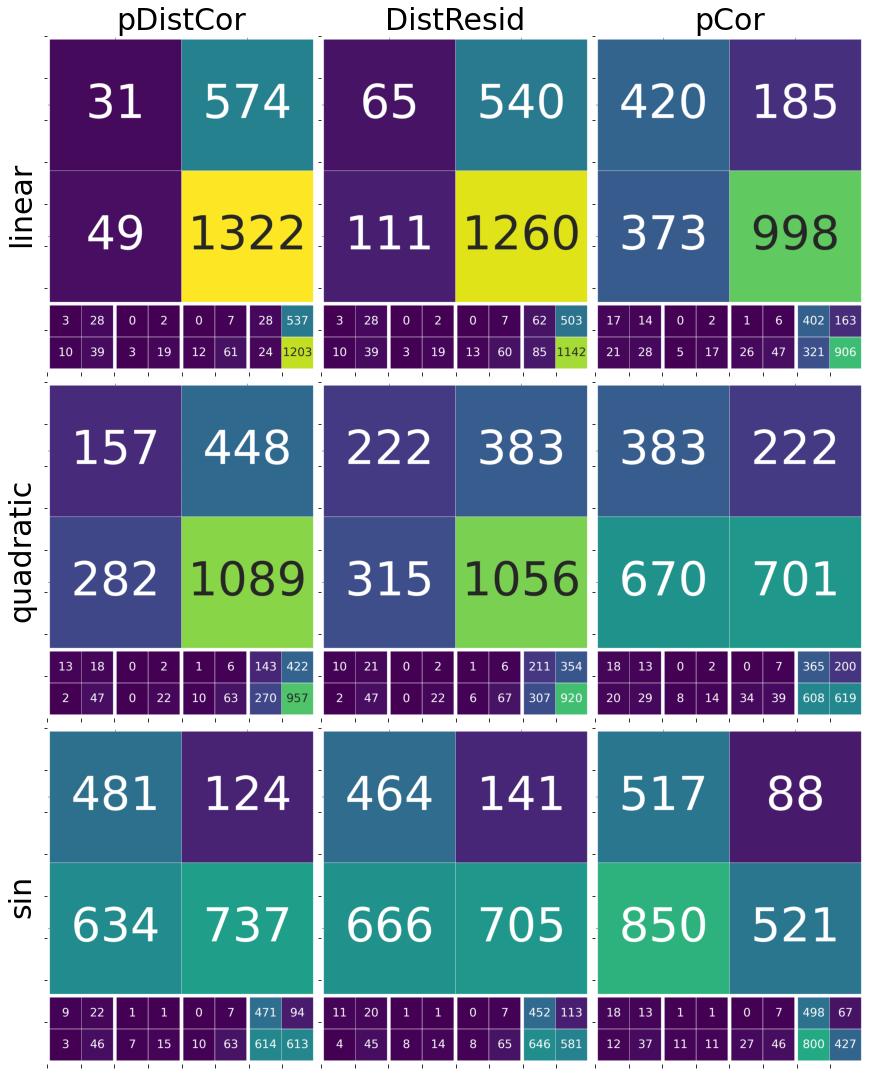

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(12, 15))
method_name = {"DistCor": "pDistCor", "DistResid":"DistResid", "partial_Cor":"pCor"}

nsamp=150

for i, parametrization in enumerate(["linear", "quadratic", "sin"]):
    for j, method in enumerate(["DistCor", "DistResid", "partial_Cor"]):
        img = mpimg.imread(f'Confusion_{method}-{nsamp}-{parametrization}.png')
        plt.sca(axes[i, j])
        plt.imshow(img)
        axes[i, j].set_xticklabels([])
        axes[i, j].set_yticklabels([])
        axes[i, j].spines['top'].set_visible(False)
        axes[i, j].spines['right'].set_visible(False)
        axes[i, j].spines['bottom'].set_visible(False)
        axes[i, j].spines['left'].set_visible(False)
        if j == 0:
            axes[i, j].set_ylabel(f"{parametrization}", size=30)
        if i == 0:
            axes[i, j].set_title(method_name[method], size=30)
plt.subplots_adjust(wspace=0.02, hspace=0.02, bottom=0.005, top=0.96, left=0.05, right=0.995)
plt.savefig(f'Confusion_matrices_at_5_lr.png', dpi=300)
